In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier

from sklearn.metrics import brier_score_loss
import joblib

In [2]:
train_df = pd.read_parquet('data/training_data_features.parquet')
val_df = pd.read_parquet('data/validation_data_features.parquet')

In [3]:
X_train = train_df.drop(columns=['id', 'events', 'event_names', 'timestamps', 'outcome', 'start_timestamp', 'end_timestamp', 'current_datetime'])
y_train = (train_df["outcome"] == 'successful').astype('int')

X_val = val_df.drop(columns=['id', 'events', 'event_names', 'timestamps', 'outcome', 'start_timestamp', 'end_timestamp', 'current_datetime'])
y_val = (val_df["outcome"] == 'successful').astype('int')

# For now, also drop days_to_milestone columns
milestone_days=r"^days_to_milestone_"
X_train = X_train.drop(columns=X_train.columns[X_train.columns.str.contains(milestone_days, regex=True)])
X_val = X_val.drop(columns=X_val.columns[X_val.columns.str.contains(milestone_days, regex=True)])

In [4]:
# TODO: IF TEAM AGREES, IMPLEMENT THIS IN THE DATA PREPROCESSING SCRIPT
# Impute quantiles with the length of the journey (in days)
cols = X_train.filter(
    regex=r"^days_between_actions_q_"
).columns

X_train_sub = X_train[cols]
X_train.loc[:, cols] = X_train_sub.where(
    X_train_sub.notna(),
    X_train["days_into_journey"],
    axis=0
)

X_val_sub = X_val[cols]
X_val.loc[:, cols] = X_val_sub.where(
    X_val_sub.notna(),
    X_val["days_into_journey"],
    axis=0
)

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer

brier_scorer = make_scorer(
    brier_score_loss,
    response_method="predict_proba",
    greater_is_better=False
)

param_grid = {
    "max_depth": [5, 8, 10],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.5, 0.8]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=331)

xgboost_model = XGBClassifier(
    objective="binary:logistic",
    n_estimators=50,
    eval_metric=brier_score_loss,
    learning_rate=0.05,
    random_state=642
)

clf = GridSearchCV(
    xgboost_model,
    param_grid,
    scoring=brier_scorer,
    cv=cv,
    n_jobs=5
)

clf.fit(X_train, y_train)

In [56]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import brier_score_loss, make_scorer

brier_scorer = make_scorer(
    brier_score_loss,
    response_method="predict_proba",
    greater_is_better=False
)

param_grid = {
    "max_depth": [10, 12, 15],
    "subsample": [1.0],
    "colsample_bytree": [0.8, 1]
}

cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=331
)

xgboost_model = XGBClassifier(
    objective="binary:logistic",
    n_estimators=50,
    learning_rate=0.05,
    eval_metric="logloss",
    random_state=642
)

clf = GridSearchCV(
    estimator=xgboost_model,
    param_grid=param_grid,
    scoring=brier_scorer,
    cv=cv,
    n_jobs=5
)

clf.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'colsample_bytree': [0.8, 1], 'max_depth': [10, 12, ...], 'subsample': [1.0]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",make_scorer(b...redict_proba')
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",5
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold an

In [58]:
best_model = clf.best_estimator_

In [57]:
clf.best_params_

{'colsample_bytree': 0.8, 'max_depth': 15, 'subsample': 1.0}

Old best params: `{'n_estimators': 50, 'colsample_bytree': 0.8, 'max_depth': 10, 'subsample': 1.0}`

New best params (initially worse than old ones): `{'n_estimators': 50, 'colsample_bytree': 0.8, 'max_depth': 15, 'subsample': 1.0}`

In [102]:
# Use best parameters but increase number of estimators
best_model = XGBClassifier(
    objective="binary:logistic",
    n_estimators=200,
    learning_rate=0.05,
    # eval_metric="logloss",
    eval_metric=brier_score_loss,
    colsample_bytree=0.8,
    max_depth=10,
    subsample=1,
    random_state=642
)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

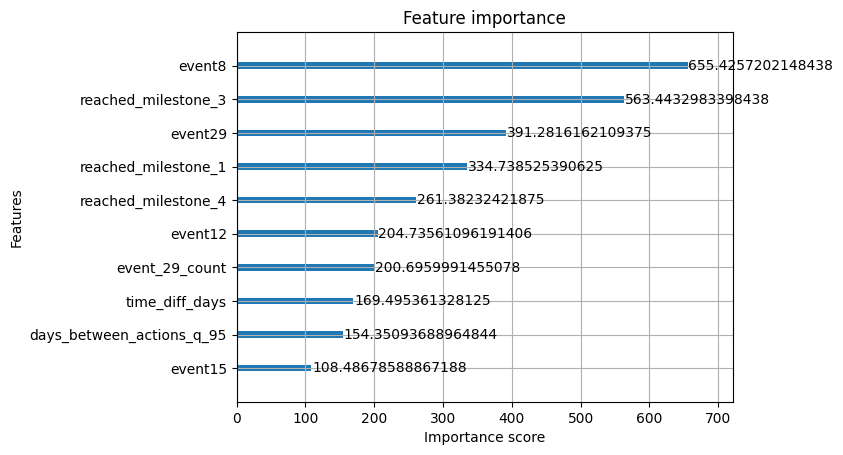

In [103]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(best_model, importance_type="gain", max_num_features=10)
plt.show()

In [121]:
importances = best_model.feature_importances_

feature_importance_df = (
    pd.DataFrame({
        "feature": X_train.columns,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

In [127]:
feature_importance_df.head()

,feature,importance
0,event8,0.148068
1,reached_milestone_3,0.127288
2,event29,0.088395
3,reached_milestone_1,0.075621
4,reached_milestone_4,0.059049


In [128]:
feature_importance_df.shape[0]

65

In [130]:
unimportant_features = feature_importance_df.tail(n=30)['feature'].values

In [132]:
X_train.drop(columns=unimportant_features, inplace=True)
X_val.drop(columns=unimportant_features, inplace=True)

In [153]:
brier_scorer = make_scorer(
    brier_score_loss,
    response_method="predict_proba",
    greater_is_better=False
)

param_grid = {
    "max_depth": [10, 12],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9]
}

cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=331
)

xgboost_model = XGBClassifier(
    objective="binary:logistic",
    n_estimators=50,
    learning_rate=0.05,
    eval_metric="logloss",
    random_state=642
)

clf = GridSearchCV(
    estimator=xgboost_model,
    param_grid=param_grid,
    scoring=brier_scorer,
    cv=cv,
    n_jobs=5
)

clf.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'colsample_bytree': [0.8, 0.9], 'max_depth': [10, 12], 'subsample': [0.8, 0.9, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",make_scorer(b...redict_proba')
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",5
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each 

In [154]:
clf.best_params_

{'colsample_bytree': 0.8, 'max_depth': 12, 'subsample': 1.0}

In [150]:
best_model = clf.best_estimator_

In [159]:
# Use best parameters but increase number of estimators
best_model = XGBClassifier(
    objective="binary:logistic",
    n_estimators=300,
    learning_rate=0.05,
    # eval_metric="logloss",
    eval_metric=brier_score_loss,
    colsample_bytree=0.8,
    max_depth=12,
    subsample=1,
    random_state=642
)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [160]:
from sklearn.metrics import classification_report

val_preds = best_model.predict(X_val)
print("\nValidation Set Performance:")
print(classification_report(y_val, val_preds))


Validation Set Performance:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97   1908478
           1       0.81      0.11      0.20    132996

    accuracy                           0.94   2041474
   macro avg       0.87      0.56      0.59   2041474
weighted avg       0.93      0.94      0.92   2041474



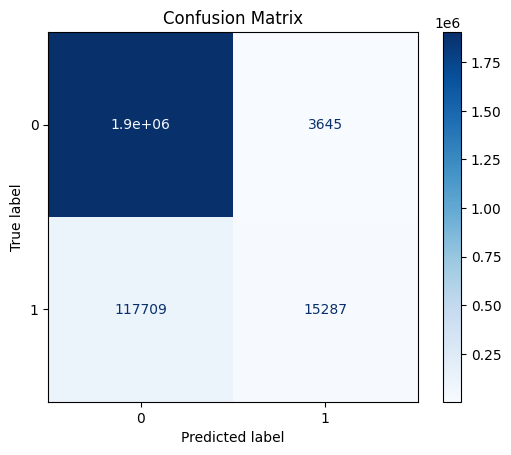

In [161]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Get predictions from your model (or GridSearchCV object)
y_pred = best_model.predict(X_val)

# 2. Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# 3. Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [162]:
from sklearn.metrics import brier_score_loss

val_preds_prob = best_model.predict_proba(X_val)[:, 1]
print(f"Brier loss on Random Forest model is {brier_score_loss(y_val, val_preds_prob)}")

Brier loss on Random Forest model is 0.051226548850536346


In [163]:
joblib.dump(best_model, 'models/xgboost_model_new.joblib')

['models/xgboost_model_new.joblib']

In [ ]:
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric=brier_score_loss,
    n_estimators=50,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=642
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

[0]	validation_0-logloss:0.23507	validation_0-brier_score_loss:0.06002
[1]	validation_0-logloss:0.23119	validation_0-brier_score_loss:0.05931
[2]	validation_0-logloss:0.22842	validation_0-brier_score_loss:0.05876
[3]	validation_0-logloss:0.22609	validation_0-brier_score_loss:0.05828
[4]	validation_0-logloss:0.22345	validation_0-brier_score_loss:0.05771
[5]	validation_0-logloss:0.22120	validation_0-brier_score_loss:0.05720
[6]	validation_0-logloss:0.21920	validation_0-brier_score_loss:0.05674
[7]	validation_0-logloss:0.21747	validation_0-brier_score_loss:0.05633
[8]	validation_0-logloss:0.21592	validation_0-brier_score_loss:0.05597
[9]	validation_0-logloss:0.21451	validation_0-brier_score_loss:0.05564
[10]	validation_0-logloss:0.21319	validation_0-brier_score_loss:0.05533
[11]	validation_0-logloss:0.21203	validation_0-brier_score_loss:0.05506
[12]	validation_0-logloss:0.21095	validation_0-brier_score_loss:0.05480
[13]	validation_0-logloss:0.20997	validation_0-brier_score_loss:0.05457
[1

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [30]:
from sklearn.metrics import brier_score_loss

val_preds_prob = model.predict_proba(X_val)[:, 1]
print(f"Brier loss on Random Forest model is {brier_score_loss(y_val, val_preds_prob)}")

Brier loss on Random Forest model is 0.051166292279958725


In [ ]:
y_pred = model.predict_proba(X_val)[:, 1]

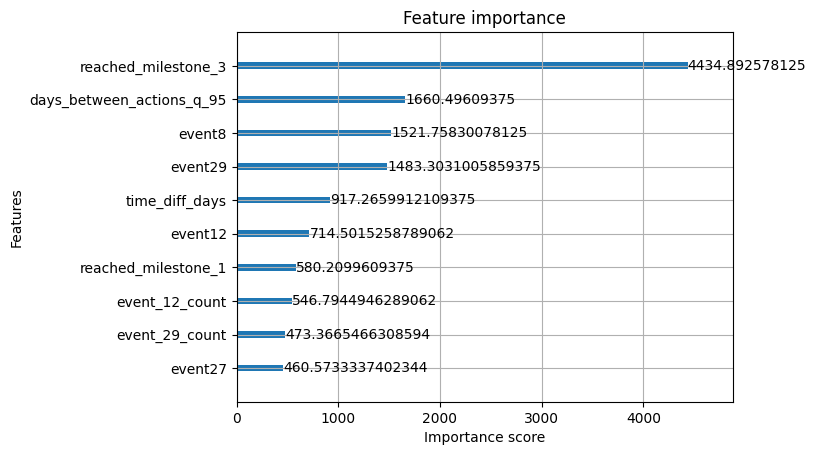

In [17]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model, importance_type="gain", max_num_features=10)
plt.show()

In [20]:
from sklearn.metrics import classification_report

val_preds = model.predict(X_val)
print("\nValidation Set Performance:")
print(classification_report(y_val, val_preds))


Validation Set Performance:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97   1908478
           1       0.82      0.11      0.20    132996

    accuracy                           0.94   2041474
   macro avg       0.88      0.56      0.58   2041474
weighted avg       0.93      0.94      0.92   2041474



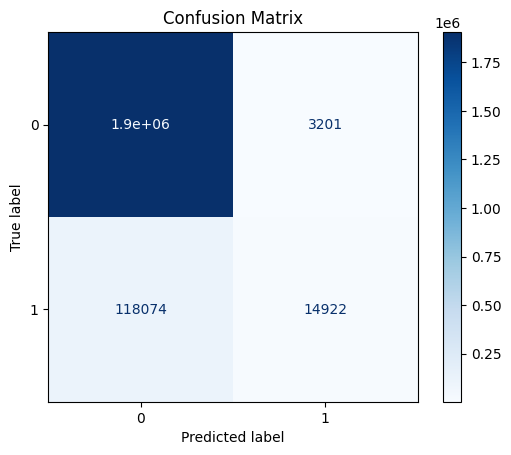

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Get predictions from your model (or GridSearchCV object)
y_pred = model.predict(X_val)

# 2. Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# 3. Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [21]:
from sklearn.metrics import brier_score_loss

val_preds_prob = model.predict_proba(X_val)[:, 1]
print(f"Brier loss on Random Forest model is {brier_score_loss(y_val, val_preds_prob)}")

Brier loss on Random Forest model is 0.051166292279958725


In [ ]:
joblib.dump(model, 'models/xgboost_model.joblib')

['models/xgboost_model.joblib']

## Test Predictions

In [22]:
test_data = pd.read_parquet("data/test_data1_features.parquet")

In [23]:
X_test = test_data.drop(columns=['id', 'events', 'event_names', 'timestamps', 'start_timestamp', 'end_timestamp', 'current_datetime'])
milestone_days=r"^days_to_milestone_"
X_test = X_test.drop(columns=X_test.columns[X_test.columns.str.contains(milestone_days, regex=True)])

In [24]:
cols = X_test.filter(
    regex=r"^days_between_actions_q_"
).columns

X_test_sub = X_test[cols]
X_test.loc[:, cols] = X_test_sub.where(
    X_test_sub.notna(),
    X_test["days_into_journey"],
    axis=0
)

In [165]:
X_test_reduced = X_test.drop(columns=unimportant_features)

In [166]:
best_model = joblib.load('models/xgboost_model_new.joblib')
# test_predictions = best_model.predict_proba(X_test)[:, 1]
test_predictions = best_model.predict_proba(X_test_reduced)[:, 1]

In [167]:
test_output = pd.DataFrame({
    'id': test_data['id'],
    'order_shipped': test_predictions
})

In [168]:
test_output.to_csv("data/xgboost_predictions_less_features.csv", index=False)